<a href="https://colab.research.google.com/github/lucasjirwin/Meta-Learning-aspiration-RL-agent/blob/main/RL_aspiration_metaLearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Senior Thesis Project:** Developing a meta-learning RL agent which sets its own aspiration level 



*   **DeepGridWorld class:** contains the grid-world environment with methods for taking a step in the environment, getting available actions and rewards, checking if a state is terminal and printing the agent on the map.
*   **DeepQ_Agent class:** contains the Q-learning agent with methods for choosing an action, updating the Q-table (learning), and getting the aspiration.  
*   **play function:** Runs iterations of the agent on the environment and updates the Q-table if required. 


**IN PROGRESS:**
*   **Meta-learner:** PyTorch optimizer + module, backpropagation through the Q_table (modelled as a tensor). **Params:** aspiration, weight_1, weight_2. **Loss:** Minimize negative mean cumulative reward 







In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import operator
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
%matplotlib inline

In [ ]:
height = np.random.randint(5,10)
width = np.random.randint(5,10)
grid = np.zeros(height * width) -1
size = height * width - 1
current_location = (np.random.randint(0,size)) #e1
bomb_location= np.random.choice([i for i in range(size) if i!= current_location])
gold_location= np.random.choice([i for i in range(size) if (i!=current_location and i!= bomb_location)])
terminal_states = [bomb_location, gold_location]
print(height, width, grid, size, current_location, bomb_location, gold_location, terminal_states)

9 8 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 71 39 44 10 [44, 10]


In [ ]:
class DeepGridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 5
        self.width = 5
        self.grid = np.zeros(self.height * self.width) -1
        self.size = self.height * self.width - 1
        
        # Set random start location for the agent 
        self.current_location = (np.random.randint(0,24)) #e1
        
        # Set locations for the bomb and the gold

        #self.bomb_location = np.random.choice([i for i in range(25) if i!=self.current_location]) # e2
        #self.gold_location = np.random.choice([i for i in range(25) if (i!=self.current_location and i!=self.bomb_location)]) # e3
        
        self.bomb_location= 3
        self.gold_location= 8
        self.terminal_states = [self.bomb_location, self.gold_location]
        
        # Set grid rewards for special cells
        self.grid[self.bomb_location] = -10
        self.grid[self.gold_location] = 10
        
        # Set available actions
        self.actions = [0, 1, 2, 3] # e4
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[self.current_location] = 1 #e5
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[new_location] # e6
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 0: # e7
            # If agent is at the top, stay still, collect reward
            if last_location < self.width: #e8 
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location - self.width) # e9
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 1:
            # If agent is at bottom, stay still, collect reward
            if last_location >= ((self.width * self.height) - self.width): #e10
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location + self.width) # e11
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 2:
            # If agent is at the left, stay still, collect reward
            if last_location % self.height == 0: # TODO e12
                reward = self.get_reward(last_location) 
            else:
                self.current_location = (self.current_location - 1) # e13
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 3:
            # If agent is at the right, stay still, collect reward
            if last_location % self.height == self.height - 1: # TODO e14
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location + 1) # e15
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)   

In [ ]:
class DeepQ_Agent(nn.Module):
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=0.99, aspiration = 0, weight_1 = 1, weight_2 = 1): # add default aspiration and weights
        super().__init__()
        self.environment = environment
        # self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        # for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
        #     for y in range(environment.width):
        #         self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.q_table = torch.zeros((environment.height*environment.width, 4), requires_grad=True) #q1
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.aspiration = aspiration
        self.weight_1 = weight_1
        self.weight_2 = weight_2
    
    # Choose the action e-greedily 
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location] # change to 1D (e1 in env)
            maxValue = torch.max(q_values_of_state) # q2
            #action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue]) # tricky index of torch.max value and random choice
            res = (q_values_of_state == maxValue).nonzero().numpy() # q3 get indices of highest value actions and convert to np array
            action = np.random.choice(res[:,0]) # choose the action randomly if there is a tie (slice for 1D array)
        
        return action
    
    # Update the Q-table based on the current observation 
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state] # index into table self.q_table[] single index numbers not tuples
        max_q_value_in_new_state = torch.max(q_values_of_state) # q4
        current_q_value = self.q_table[old_state][action]
        # define reward with aspiration = w_1 * reward + w_2 * (reward - aspiration)
        reward = self.get_aspiration(reward)
        self.q_table.data[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)
    
    # Transform the reward function using the aspiration formula #Define aspiration in another way for autograd
    def get_aspiration(self, reward):
      return self.weight_1 * reward + self.weight_2 * (reward - self.aspiration)
    
    def play(self,trials=500, max_steps_per_episode=1000, learn=False):
      """The play function runs iterations and updates Q-values if desired."""
      reward_per_episode = torch.empty(0, requires_grad=True) # Initialise performance log
      self.q_table = torch.zeros((environment.height*environment.width, 4)) # reset q table
      
      for trial in range(trials): # Run trials
          cumulative_reward = 0 # Initialise values of each game
          step = 0
          game_over = False
          while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
              old_state = self.environment.current_location
              action = self.choose_action(self.environment.actions) 
              reward = self.environment.make_step(action)
              new_state = self.environment.current_location
              
              if learn == True: # Update Q-values if learning is specified
                  self.learn(old_state, reward, new_state, action)
                  
              cumulative_reward += reward
              step += 1
              
              if self.environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                  self.environment.__init__()
                  game_over = True     
                  
          reward_per_episode = torch.cat([reward_per_episode, torch.tensor([cumulative_reward])]) # Append reward for current trial to performance log
          
      return reward_per_episode # Return performance log


    
    def forward(self,x,trials=10):
      # self.aspiration=x[0]
      # self.weight_1=x[1]
      # self.weight_2=x[2]
      #self.aspiration = x
      rewards=self.play(trials=trials,learn=True)
      #tensor_reward=torch.tensor(rewards,requires_grad=True)
     # mean_reward = torch.tensor(torch.mean(tensor_reward), requires_grad=True). #sourceTensor.clone().detach().requires_grad_(True)
      return torch.mean(rewards) #return medium rewards 




In [ ]:
reward_per_episode = torch.zeros(1, requires_grad=True)
reward_per_episode.add(1)

tensor([1.], grad_fn=<AddBackward0>)

In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

### Testing Torch version of play for autograd:

In [ ]:
# def new_play(environment, agent,trials=500, max_steps_per_episode=1000, learn=False):
#       """The play function runs iterations and updates Q-values if desired."""
#       reward_per_episode = torch.empty(0, requires_grad=True) # Initialise performance log
      
#       for trial in range(trials): # Run trials
#           cumulative_reward = 0 # Initialise values of each game
#           step = 0
#           game_over = False
#           while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
#               old_state = environment.current_location
#               action = agent.choose_action(environment.actions) 
#               reward = environment.make_step(action)
#               new_state = environment.current_location
              
#               if learn == True: # Update Q-values if learning is specified
#                   agent.learn(old_state, reward, new_state, action)
                  
#               cumulative_reward += reward
#               step += 1
              
#               if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
#                   environment.__init__()
#                   game_over = True     
                  
#           reward_per_episode = torch.cat([reward_per_episode, torch.tensor([cumulative_reward])]) # Append reward for current trial to performance log
          
#       return reward_per_episode # Return performance log

In [ ]:
environment = DeepGridWorld()
agent = DeepQ_Agent(environment, aspiration = 0)
av_reward = 0 
for iteration in range(10):
  reward_per_episode = play(environment, agent, trials = 500, learn = True)

  #plt.plot(reward_per_episode)
  av_reward += sum(reward_per_episode) 

print(av_reward/10)

KeyboardInterrupt: ignored

### Testing aspiration (100 iterations, 500 trials)  
2184.75, aspiration = 0.5 \\
2182.38       , aspiration = 0.2 \\
2195.28      , aspiration = 0.08 \\
2181.2      , aspiration = 0.05 \\
2188.52, aspiration = 0 


torch.Size([25, 4])
7.0


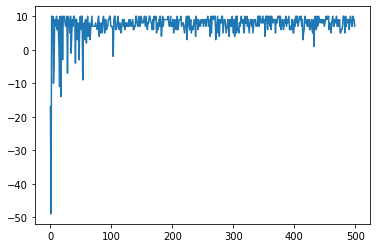

In [ ]:
environment = DeepGridWorld()
agent = DeepQ_Agent(environment, aspiration = 0.20173071)
av_reward = 0 
print(agent.q_table.shape)
reward_per_episode = agent.play( learn = True)

plt.plot(reward_per_episode.detach().numpy())
#print(reward_per_episode)
print(np.mean(reward_per_episode.detach().numpy()[-1:]))


In [ ]:
means = []

for it in range(100):
  environment = DeepGridWorld()
  agent = DeepQ_Agent(environment, aspiration = 0.20173071)
  reward_per_episode = play(environment, agent, trials=100, learn = True)
  means.append(reward_per_episode[-15:])

np.mean(means)

4.334666666666666

### Testing Evolutionary Algorithms

In [ ]:
def optimize(aspiration):
    environment = DeepGridWorld()
    agent = DeepQ_Agent(environment,aspiration = aspiration)
    reward_per_episode = agent.play(learn = True)
    return -np.mean(reward_per_episode.detach().numpy()[-15:])
    
varbound=np.array([[0,1]])

algorithm_param = {'max_num_iteration': 100,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function= optimize,dimension=1,variable_type='real',variable_boundaries=varbound, algorithm_parameters = algorithm_param)

model.run() # optimal = 0.20173071

TypeError: ignored

### Testing the Optimizer which acts as a meta-learner:

In [ ]:
params=nn.Parameter(torch.tensor([0.1], requires_grad=True))
optimizer=torch.optim.SGD([agent.aspiration],lr=0.1,momentum=0.9)
environment = DeepGridWorld()
for outer_trial in range(10):
  mean_reward=agent(params,trials=500)
  loss=-mean_reward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step() 
  print(agent.aspiration)

  




Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)


KeyboardInterrupt: ignored

In [ ]:
weight_1=nn.Parameter(torch.tensor(1.0))
weight_2=nn.Parameter(torch.tensor(1.0))
aspiration=nn.Parameter(torch.tensor(0.05))


tensor([1.0000, 1.0000, 0.0500], grad_fn=<StackBackward0>)

In [ ]:
params=nn.Parameter(torch.tensor([0.0]),requires_grad=True)
optimizer=torch.optim.Adam([params], lr = 0.1)
environment = DeepGridWorld()
for outer_trial in range(10):
  environment.__init__()
  optimizer.zero_grad()
  mean_reward=agent(params,trials=500)
  negative_mean_reward=-mean_reward
  negative_mean_reward.backward()
  optimizer.step() 
  print(agent.aspiration)
  

Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)


KeyboardInterrupt: ignored

In [ ]:
import torch

# Define a PyTorch model for the gamma value
class GammaModel(torch.nn.Module):
  def __init__(self):
    super(GammaModel, self).__init__()
    self.gamma = torch.nn.Parameter(torch.tensor(0.5))
  
  def forward(self):
    return self.gamma

# Define a function for evaluating the performance of the gamma model
def evaluate_gamma_model(model, env, agent, num_episodes):
  total_reward = 0
  for i in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
      action = agent.act(state, gamma=model())
      next_state, reward, done, _ = env.step(action)
      total_reward += reward
      state = next_state
  return total_reward

# Define a function for training the gamma model
def train_gamma_model(model, optimizer, env, agent, num_episodes, num_iterations):
  for i in range(num_iterations):
    optimizer.zero_grad()
    reward = evaluate_gamma_model(model, env, agent, num_episodes)
    loss = -reward  # maximize reward by minimizing the negative reward
    loss.backward()
    optimizer.step()

# Create the gamma model and optimizer
model = GammaModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the gamma model
train_gamma_model(model, optimizer, env, agent, num_episodes=100, num_iterations=100)

# The trained model's gamma value is the optimal gamma value
optimal_gamma = model()